### 準備

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 学習済みのU-Netを適用

In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from IPython.display import Image

import os
import shutil
import sys

from segmentation.utils import torch_fix_seed, integrate_edges
from segmentation.model import UNet_2D

from hough.hough import hough_transform_CSD

In [3]:
!ls

hough  requirements.txt  segmentation  test.ipynb


In [4]:
# 入力画像パス
input_img   = "../inputs/hitachi/raw/original/1.png"         # 元画像
# 出力先ディレクトリパス
dir_output = "../outputs/infer"
# 適用するモデル
load_model = "../models/finetune/finetune_11.pth"

Output size: (96, 96)


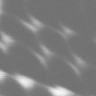

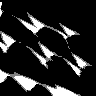

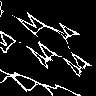

In [5]:
torch_fix_seed()

# フォルダ準備
if os.path.exists(dir_output):
  shutil.rmtree(dir_output)

os.mkdir(dir_output) 

shutil.copy(load_model, dir_output)

# 分類するクラス数
classes = 3

# GPU, Optimizer, Loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet_2D(classes=classes).to(device)
if torch.cuda.is_available():
    model.load_state_dict(torch.load(load_model))
else:
    model.load_state_dict(torch.load(load_model, map_location=torch.device('cpu')))

sigmoid = nn.Sigmoid()

# 入力画像を読み込み、解像度調整
img_orig = cv2.imread(input_img)
required_height = [i for i in range(img_orig.shape[0] - 15, img_orig.shape[0] + 1) if i % 16 == 0]
required_width = [i for i in range(img_orig.shape[1] - 15, img_orig.shape[1] + 1) if i % 16 == 0]
print(f"Output size: ({required_height[0]}, {required_width[0]})")
img = cv2.resize(img_orig, dsize = (required_width[0], required_height[0]))

img = img/255
img = torch.from_numpy(img.astype(np.float32)).clone()
img = img.permute(2, 0, 1)
img = img.unsqueeze(0)

output = model(img)
output = sigmoid(output)
pred = torch.argmax(output, dim=1)
pred = torch.nn.functional.one_hot(pred.long(), num_classes=classes).to(torch.float32)

orig = img[0,0,:,:].cpu().numpy()
cv2.imwrite(dir_output + "/original.png", orig*255)

pred_np = torch.argmax(pred[0,:,:,:], dim=2).cpu().numpy()
cv2.imwrite(dir_output + f"/pred.png", pred_np*255//(classes-1))
cv2.imwrite(dir_output + f"/pred_binary.png", np.where(pred_np != 0, 1, pred_np)*255)
for j in range(classes):
      if j != 0:
        pred_np = pred[0,:,:,j].cpu().numpy()
        cv2.imwrite(dir_output + f"/pred_class{j}.png", pred_np*255)

integrate_edges(
   dir_output+"/pred_class1.png",
   dir_output+"/pred_class2.png",
   dir_output+"/integrated_edge.png"
)

display(Image(filename=dir_output+"/original.png"))
display(Image(filename=dir_output+"/pred.png"))
display(Image(filename=dir_output+"/integrated_edge.png"))

### 直線パラメータ推定

In [13]:
# 対象画像の二値画像パス (ex. integrated_edge.png)
filepath = dir_output+"/integrated_edge.png"

# 出力先ディレクトリパス
output_folder = "../outputs/hough"

# rho-theta空間上で検出した直線のうち, 投票数がこれ未満/以上のものを無視する.
lower_threshold: int = 13
upper_threshold: int = 13

# (任意) 傾き正の直線検出に, 独自の閾値を使用したい場合は設定する.
lower_threshold_interdot: int = None
upper_threshold_interdot: int = None

In [15]:
hough_transform_CSD(
    method="slope_intercept",
    filepath=filepath,
    output_folder=output_folder,
    edge_extraction=False,
    thinning=False,
    lower_threshold=lower_threshold,
    upper_threshold=upper_threshold,
    lower_threshold_interdot=lower_threshold_interdot,
    upper_threshold_interdot=upper_threshold_interdot,
)

[[False  True False ... False False False]
 [False False  True ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[  1   1   2   5   6   7   7   9  11  12  13  13  13  14  15  15  15  17
   17  18  20  20  21  21  21  21  21  22  24  24  27  29  31  33  34  35
   35  35  35  36  37  37  37  37  38  38  38  39  40  41  41  44  45  49
   49  49  50  52  52  52  52  54  55  55  55  56  56  60  60  61  62  65
   67  67  69  70  74  77  77  79  80  82  83  84  85  86  87  88  90  90
   92  97  98 101]
 [  2  42   3   2   7   7  54  53   9  52   8  51  52  51  11  51  76  12
   74  12  14  47   4  14  69  70  71  70  47  67  66  17  18   1   8  15
   16  20  26  21  18  19  21  51   2   3  19  19  21  20  21  23  29  29
   30  48  30  27  28  30  33  31  30  31  40  30  34  32  35  44  43  44
   34  44  37  36  16  13  39  42  49  40  19  43  

In [ ]:
# 検出した直線を確認
